<a href="https://colab.research.google.com/github/bill-unitech2021/BDS2-Lightning/blob/main/race_religion_gender_bias_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pwd

'/content'

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 27 22:19:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.2 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [6]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


### Load Dataset

In [7]:
#from google.colab import files
#uploaded = files.upload()
!pwd

/content


In [8]:
data1 = pd.read_csv("aug_gender_bias_df.csv")
data1.shape

(6600, 3)

In [9]:
data2 = pd.read_csv("stereoset_intra_labeled.csv")
data2.shape

(4170, 2)

In [10]:
df = pd.concat([data1, data2], ignore_index=True)
df.shape



(10770, 3)

In [11]:
#filtered_df = df[df['word_labels'].str.contains('religion')]
#filtered_df.shape

In [12]:
data = df

In [13]:
temp_labels = ['O', 'race', 'religion', 
                'Generic she', 'Generic he',
               'Behavioural Stereotypes', 
               'Societal Stereotypes', 
               'Explicit Marking of Sex']



label2id = {k: v for v, k in enumerate(temp_labels)}
id2label = {v: k for v, k in enumerate(temp_labels)}  
label2id

{'O': 0,
 'race': 1,
 'religion': 2,
 'Generic she': 3,
 'Generic he': 4,
 'Behavioural Stereotypes': 5,
 'Societal Stereotypes': 6,
 'Explicit Marking of Sex': 7}

### Initialize required parameters

In [14]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Pytorch dataset class implementation

In [15]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]  
        word_labels = self.data.word_labels[index]  
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)
        
        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
            tokenized_sentence = tokenized_sentence[:maxlen]
            labels = labels[:maxlen]
        else:
          # pad
            tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
            labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]
        
        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

### Divide dataset into test and train

### Helper functions(tokenization, training)

In [16]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs[0], outputs[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_preds.extend(predictions)
        tr_labels.extend(targets)
        
        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [17]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (10770, 3)
TRAIN Dataset: (8616, 3)
TEST Dataset: (2154, 3)


In [18]:
# print the first 30 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[2]["ids"][:15]), training_set[0]["targets"][:15]):
    print('{0:10}  {1}'.format(token, id2label[label.item()]))

[CLS]       O
my          O
friend      O
who         O
is          O
hispanic    O
likes       O
spicy       O
food        O
.           O
[SEP]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O


### Initialize Pytorch dataloaders

In [19]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [20]:
test_dataset.to_csv("test_final.csv", index=False)
train_dataset.to_csv("train_final.csv", index=False)

### Initialize model and optimizer

In [21]:
#model = BertForTokenClassification.from_pretrained("model", from_tf=False) # From already pretrained model
model = BertForTokenClassification.from_pretrained('bert-base-uncased', 
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

### Training

In [22]:
for epoch in range(10):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 1.9748815298080444
Training loss per 100 training steps: 0.2972376708789627
Training loss per 100 training steps: 0.18692359531214878
Training loss per 100 training steps: 0.144690824777779
Training loss per 100 training steps: 0.11982414491028709
Training loss per 100 training steps: 0.10318321124009208
Training loss per 100 training steps: 0.09090822576676896
Training loss per 100 training steps: 0.08218392978067618
Training loss per 100 training steps: 0.07490979334323222
Training loss per 100 training steps: 0.06907425521687914
Training loss per 100 training steps: 0.06428145561376578
Training loss per 100 training steps: 0.060281082513242226
Training loss per 100 training steps: 0.05673045400575852
Training loss per 100 training steps: 0.05379753548964761
Training loss per 100 training steps: 0.051269389141210056
Training loss per 100 training steps: 0.04892298973569997
Training loss per 100 training steps: 0.0468232844504519

### Validation

In [23]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs[0], outputs[1]
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(targets)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy
    
    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [24]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 8.777196853770874e-06
Validation loss per 100 evaluation steps: 0.002614456384097787
Validation loss per 100 evaluation steps: 0.0033391924123237398
Validation loss per 100 evaluation steps: 0.003347425565921653
Validation loss per 100 evaluation steps: 0.003273916764204356
Validation loss per 100 evaluation steps: 0.003469449478532392
Validation loss per 100 evaluation steps: 0.0030926563155909705
Validation loss per 100 evaluation steps: 0.003213185143212988
Validation loss per 100 evaluation steps: 0.0029351567127911737
Validation loss per 100 evaluation steps: 0.002994733451445877
Validation loss per 100 evaluation steps: 0.00290959206627217
Validation Loss: 0.0028789781675933046
Validation Accuracy: 0.9948627733584499


In [25]:
from sklearn.metrics import classification_report

# calculate additional metrics
report = classification_report(labels, predictions, digits=9)
print(f"Classification Report:\n{report}")

Classification Report:
                         precision    recall  f1-score   support

Behavioural Stereotypes  0.915175097 0.988235294 0.950303030      1190
Explicit Marking of Sex  0.938967136 0.990099010 0.963855422       202
             Generic he  0.990338164 0.990338164 0.990338164       207
            Generic she  0.989637306 0.989637306 0.989637306       193
                      O  0.998926361 0.995186712 0.997053030     31787
   Societal Stereotypes  0.989071038 0.989071038 0.989071038       549
                   race  0.993193972 0.995614035 0.994402531      2052
               religion  0.960176991 0.995412844 0.977477477       218

               accuracy                      0.994807407     36398
              macro avg  0.971935758 0.991699300 0.981517250     36398
           weighted avg  0.995053425 0.994807407 0.994875766     36398



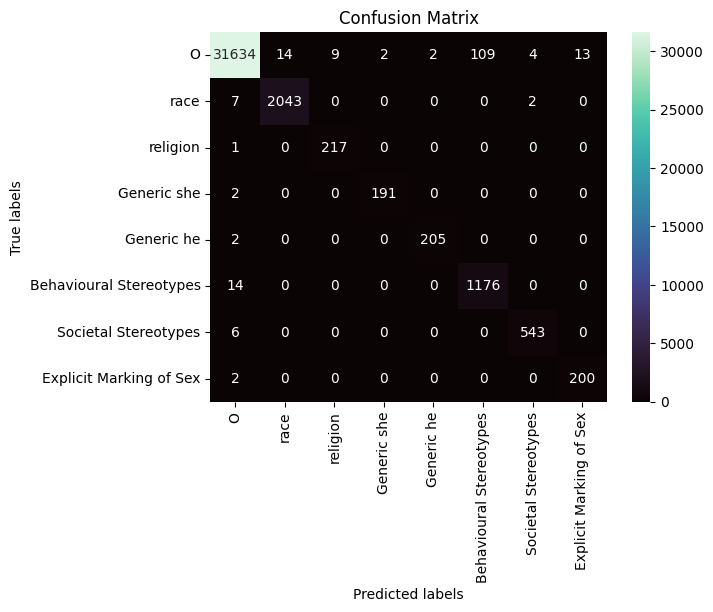

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


label_list = ['O', 'race', 'religion', 
                'Generic she', 'Generic he',
               'Behavioural Stereotypes', 
               'Societal Stereotypes', 
               'Explicit Marking of Sex']

# Create confusion matrix
conf_mat = confusion_matrix(labels, predictions, labels=label_list)


# Plot confusion matrix using seaborn heatmap

sns.heatmap(conf_mat, annot=True, fmt='.0f', xticklabels=label_list, yticklabels=label_list, cmap='mako')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Save model

In [27]:
import os
folder_name = "/content/gdrive/MyDrive/bias_detection_syetem/race_and_religion_bias/model_v2" # Pick name and path for the folder you want to save the model in
os.makedirs(folder_name)
model.save_pretrained(folder_name)